In [1]:
pip install pyproj geopandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

In [34]:
crime = pd.read_csv("crime_preprocessed_for_model")

In [35]:
crime

,DOW,HourofDay,DaysAgo,OffenseDate,LAT,LON,ExtractedMonth,ExtractedDay,UCRdesc_numeric,OffenseYear_numeric,TimeGroup_numeric,TimeBlock_numeric
0,6,22,9,2024-06-01 03:40:00,41.556885,-81.568566,6,1,10,8,4,1
1,7,7,8,2024-06-01 12:00:00,41.528059,-81.631364,6,1,4,8,4,2
2,6,21,9,2024-06-01 02:15:00,41.514356,-81.619666,6,1,3,8,4,1
3,4,15,11,2024-05-29 20:41:00,41.440774,-81.619782,5,29,3,8,4,0
4,3,6,12,2024-05-28 11:00:00,41.489449,-81.647251,5,28,24,8,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...
637788,7,2,3074,2016-01-09 07:00:00,41.480948,-81.764910,1,9,4,0,3,3
637789,1,15,3073,2016-01-10 20:41:00,41.441018,-81.717836,1,10,3,0,3,0
637790,1,11,3073,2016-01-10 16:00:00,41.494345,-81.646493,1,10,24,0,3,0
637791,5,15,3076,2016-01-07 20:10:00,41.469973,-81.789100,1,7,24,0,3,0


In [36]:
violent_crime_list = [3, 10, 27, 21, 17, 20, 22, 15]
violent_crime = crime[crime['UCRdesc_numeric'].isin(violent_crime_list)]

In [37]:
import pandas as pd
import geopandas as gpd
from pyproj import Proj

# Assuming your DataFrame is named 'crime'
# Define a UTM projection for Cleveland (Zone 17T is appropriate for Cleveland)
proj = Proj(proj="utm", zone=17, ellps="WGS84", datum="WGS84")

# Convert latitude and longitude to UTM (in meters)
violent_crime['UTM_x'], violent_crime['UTM_y'] = proj(violent_crime['LON'].values, violent_crime['LAT'].values)

# Define the size of the grid (1000 feet = 304.8 meters)
grid_size = 609.6  # in meters

# Create a function to assign each point to a grid cell
def assign_to_grid(x, y, grid_size):
    return (int(x // grid_size), int(y // grid_size))

# Apply the function to create grid cells for each crime event
violent_crime['Grid_Cell'] = violent_crime.apply(lambda row: assign_to_grid(row['UTM_x'], row['UTM_y'], grid_size), axis=1)

num_unique_tiles = violent_crime['Grid_Cell'].nunique()
print(num_unique_tiles)

C:\Users\singh\AppData\Local\Temp\ipykernel_19016\1929535747.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  violent_crime['UTM_x'], violent_crime['UTM_y'] = proj(violent_crime['LON'].values, violent_crime['LAT'].values)
C:\Users\singh\AppData\Local\Temp\ipykernel_19016\1929535747.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  violent_crime['UTM_x'], violent_crime['UTM_y'] = proj(violent_crime['LON'].values, violent_crime['LAT'].values)


770


C:\Users\singh\AppData\Local\Temp\ipykernel_19016\1929535747.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  violent_crime['Grid_Cell'] = violent_crime.apply(lambda row: assign_to_grid(row['UTM_x'], row['UTM_y'], grid_size), axis=1)


In [40]:
violent_crime['OffenseDate'] = pd.to_datetime(violent_crime['OffenseDate'], format='%Y %m %d')

# Group by grid cell and resample by day to create a time series for each tile
violent_crime_time_series = violent_crime.groupby(['Grid_Cell', pd.Grouper(key='OffenseDate', freq='W')]).size().reset_index(name='Crime_Count')

# Now 'crime_time_series' contains the number of crimes per day for each grid cell
violent_crime_time_series

C:\Users\singh\AppData\Local\Temp\ipykernel_19016\3940914757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  violent_crime['OffenseDate'] = pd.to_datetime(violent_crime['OffenseDate'], format='%Y %m %d')


,Grid_Cell,OffenseDate,Crime_Count
0,"(688, 7523)",2017-07-09,1
1,"(690, 7525)",2016-07-24,1
2,"(690, 7525)",2017-09-17,1
3,"(693, 7488)",2023-10-22,1
4,"(695, 7520)",2021-04-04,1
...,...,...,...
104447,"(767, 7502)",2023-08-20,2
104448,"(767, 7523)",2016-02-21,1
104449,"(768, 7472)",2020-08-23,1
104450,"(768, 7541)",2021-05-02,2


In [41]:
violent_crime_multiple = violent_crime_time_series[violent_crime_time_series['Crime_Count'] > 5]
violent_crime_multiple

,Grid_Cell,OffenseDate,Crime_Count
364,"(705, 7520)",2023-10-01,6
974,"(707, 7524)",2020-07-26,6
1028,"(707, 7524)",2023-01-15,7
1252,"(707, 7525)",2023-06-04,6
2926,"(710, 7524)",2020-06-14,6
...,...,...,...
103793,"(745, 7552)",2020-10-04,6
103804,"(745, 7552)",2021-01-31,6
103884,"(745, 7552)",2023-04-09,6
103901,"(745, 7552)",2024-01-07,6


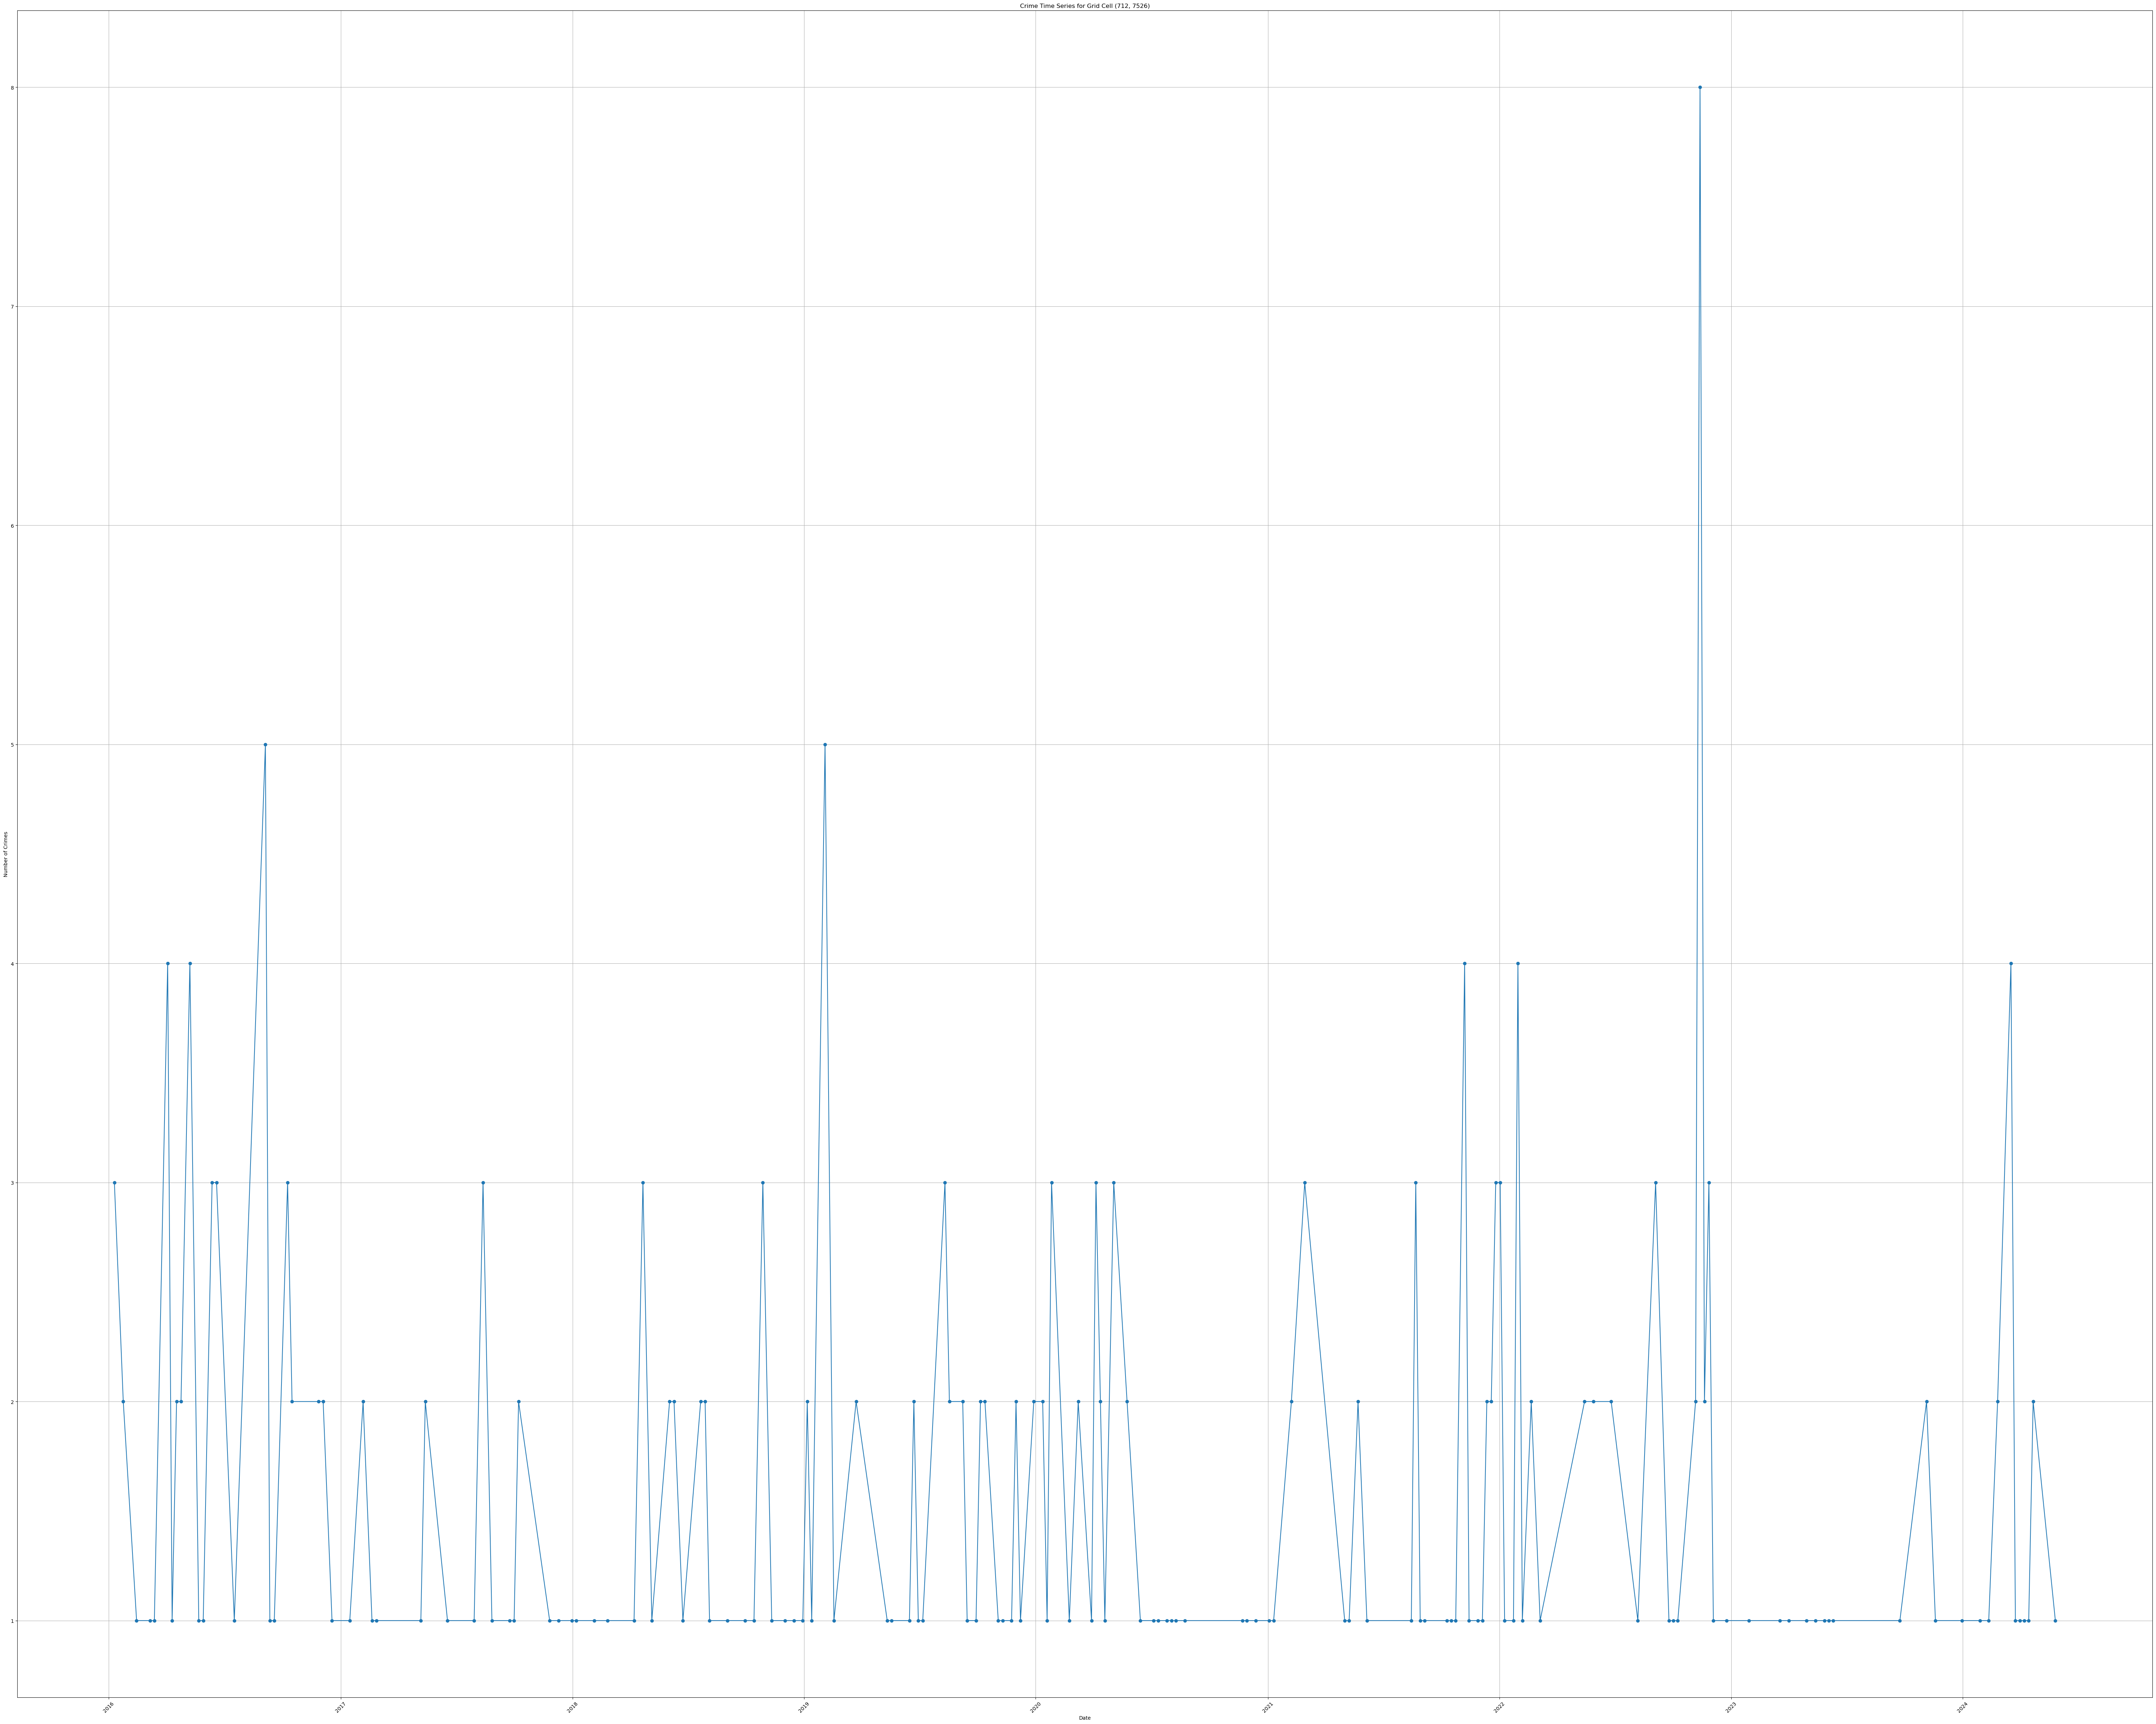

In [42]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Filter data for a specific grid cell, e.g., (x, y)
grid_cell = (712, 7526)
time_series_data = violent_crime_time_series[violent_crime_time_series['Grid_Cell'] == grid_cell]

# Plot the time series for that grid cell
plt.figure(figsize=(60, 48))
plt.plot(time_series_data['OffenseDate'], time_series_data['Crime_Count'], marker='o')
plt.title(f'Crime Time Series for Grid Cell {grid_cell}')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')

plt.xticks(rotation=45)

plt.grid(True)

plt.tight_layout()

plt.show()

In [43]:
violent_crime.shape[0]

213504

In [56]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import time
import seaborn as sns

# Ensure OffenseDate is in datetime format
violent_crime['OffenseDate'] = pd.to_datetime(violent_crime['OffenseDate'], format='%Y-%m-%d')

# Group by Grid_Cell and OffenseDate to get daily crime counts per grid cell
crime_time_series = violent_crime.groupby(['Grid_Cell', pd.Grouper(key='OffenseDate', freq='D')]).size().reset_index(name='Crime_Count')

# Fill missing dates (days with no crime) for each grid cell with 0 crimes
all_dates = pd.date_range(start=crime_time_series['OffenseDate'].min(), end=crime_time_series['OffenseDate'].max(), freq='D')
grid_cells = crime_time_series['Grid_Cell'].unique()

# Create a full DataFrame with all grid cells and all dates
all_grid_cells = pd.MultiIndex.from_product([grid_cells, all_dates], names=['Grid_Cell', 'OffenseDate'])
full_crime_data = pd.DataFrame(index=all_grid_cells).reset_index()

# Merge with the original time series and fill missing Crime_Count with 0
full_crime_data = full_crime_data.merge(crime_time_series, on=['Grid_Cell', 'OffenseDate'], how='left')
full_crime_data['Crime_Count'] = full_crime_data['Crime_Count'].fillna(0)

# Sort the data by Grid_Cell and OffenseDate
full_crime_data = full_crime_data.sort_values(by=['Grid_Cell', 'OffenseDate'])

# Lag features: Create features based on previous days' crime counts (e.g., last 7 days)
for lag in range(1, 8):
    full_crime_data[f'Crime_Count_Lag_{lag}'] = full_crime_data.groupby('Grid_Cell')['Crime_Count'].shift(lag)

# Drop rows with NaN values (due to lagging)
full_crime_data = full_crime_data.dropna()

# Sample half of the dataset (300k entries)
full_crime_data_sampled = full_crime_data.sample(n=500, random_state=42)

# Features (previous crime counts) and target (future crime count)
X = full_crime_data_sampled[[f'Crime_Count_Lag_{lag}' for lag in range(1, 8)]]
y = full_crime_data_sampled['Crime_Count']

# Train-test split: Use the last 20% of data for testing
train_size = int(0.8 * len(full_crime_data_sampled))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Random Forest with Progress Bar and Estimated Time Halving Update
class ProgressRandomForestRegressor(RandomForestRegressor):
    def fit(self, X, y):
        # Start time for calculating elapsed and estimated remaining time
        start_time = time.time()
        remaining_time = None  # Initialize remaining time
        last_reported_time = None  # Track the last time we reported
        halfway_reported = False  # Ensure we only report the halfway point once
        
        # Custom tqdm wrapper to show progress for Random Forest
        for i in tqdm(range(self.n_estimators), desc="Training Progress", leave=True):
            super(RandomForestRegressor, self).fit(X, y)
            elapsed_time = time.time() - start_time
            estimated_remaining_time = (elapsed_time / (i + 1)) * (self.n_estimators - (i + 1))
            
            if not halfway_reported and estimated_remaining_time <= (remaining_time or estimated_remaining_time) / 2:
                halfway_reported = True
                print(f'Estimated Time Left (Halfway): {estimated_remaining_time:.2f} seconds')

            remaining_time = estimated_remaining_time
            print(f'Estimated Time Left: {estimated_remaining_time:.2f} seconds')

        return self
    
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 1000],
    'max_depth': [20, 40, None],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 4, 10],
    'bootstrap': [True, False]
}

progress_rf = ProgressRandomForestRegressor(random_state=42)

# Initialize GridSearchCV with RandomForest
grid_search = GridSearchCV(estimator=progress_rf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Create a DataFrame to store the results
results_df = pd.DataFrame(grid_search.cv_results_)

# Filter out important columns for the report
results_df = results_df[['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 
                         'param_min_samples_leaf', 'param_bootstrap', 'mean_test_score', 'rank_test_score']]

# Sort by rank and display
results_df = results_df.sort_values(by='rank_test_score')
print(results_df)

# Plot performance graph for the best model
best_rf = grid_search.best_estimator_

# Make predictions with the best estimator
y_test_pred = best_rf.predict(X_test)

# Calculate RMSE for test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print(f'Testing RMSE with Best Parameters: {test_rmse}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.title('Actual vs Predicted Crime Counts with Best Parameters')
plt.xlabel('Actual Crime Counts')
plt.ylabel('Predicted Crime Counts')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.grid(True)
plt.show()

# Group by parameters and calculate mean to handle duplicates
results_grouped = results_df.groupby(['param_n_estimators', 'param_max_depth']).mean().reset_index()

# Use pivot_table to handle duplicates
pivot_table = results_grouped.pivot_table(values='mean_test_score', 
                                          index='param_n_estimators', 
                                          columns='param_max_depth')

# Heatmap of model performance across different parameter combinations
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu")
plt.title('Heatmap of Model Performance (Mean Test Score)')
plt.show()

Fitting 3 folds for each of 216 candidates, totalling 648 fits


In [22]:
results_df

,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_bootstrap,mean_test_score,rank_test_score
58,300,40,20,4,True,-0.005688,1
94,300,None,20,4,True,-0.005688,1
22,300,20,20,4,True,-0.005688,1
154,300,40,20,2,False,-0.006142,4
118,300,20,20,2,False,-0.006142,4
...,...,...,...,...,...,...,...
145,200,40,5,2,False,-0.093729,211
181,200,None,5,2,False,-0.093729,211
147,1000,40,5,2,False,-0.093729,214
111,1000,20,5,2,False,-0.093729,214
